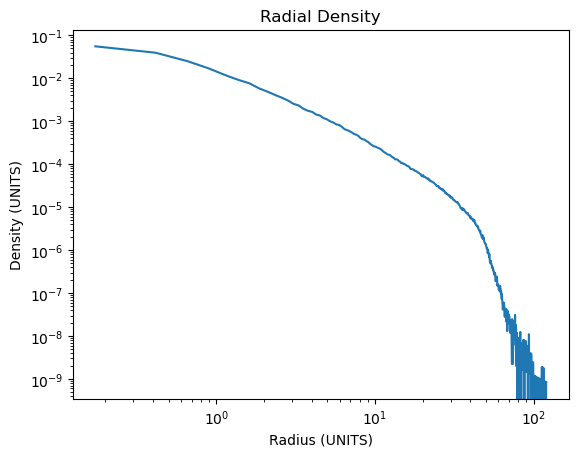

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

data = h5py.File("cutout_598597.hdf5", 'r')

coords = np.array(data["PartType1"]["Coordinates"])
coordsx = coords[:,0]
coordsy = coords[:,1]
coordsz = coords[:,2]

#all particles have the same mass, so the centre of mass is mass independent.
masstable = data["Header"].attrs["MassTable"]
particle_mass = masstable[1]

def plot_density_profile(coords, nr_bins, particle_mass):
    com_coord = np.sum(coords,axis=0) / len(coords)
    coords_centred = coords - com_coord
    com_dist = np.sqrt(np.sum(coords_centred**2, axis=1))

    #logarithmic bins
    r_min = np.min(com_dist)
    r_max = np.max(com_dist)
    bins = np.logspace(np.log10(r_min), np.log10(r_max), nr_bins + 1)

    bin_counts, bin_edges = np.histogram(com_dist, nr_bins)

    bin_inner_bound = bin_edges[:-1]
    bin_outer_bound = bin_edges[1:]
    bin_volume = (4/3)*np.pi*(bin_outer_bound**3 - bin_inner_bound**3)
    bin_density = bin_counts*particle_mass / bin_volume
    bin_centre = (bin_outer_bound + bin_inner_bound) / 2

    plt.loglog(bin_centre, bin_density)
    plt.xlabel("Radius (UNITS)")
    plt.ylabel("Density (UNITS)")
    plt.title("Radial Density")
    plt.show()

plot_density_profile(coords, 500, particle_mass)